In [1]:
import pandas as pd 
import numpy as np 
import pyodbc 

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import pyodbc

server = 'GABER'
database = 'INSTANT TRAINING' 

try:
    cnxn = pyodbc.connect(
        'DRIVER={ODBC Driver 17 for SQL Server};'
        'SERVER=' + server + ';'
        'DATABASE=' + database + ';'
        'Trusted_Connection=yes;'
    )
    print("Connection to the database is successful.")
    query = """
    SELECT
        t.*,
        u.per_capita_income,   -- الاسم الصح للعمود
        u.yearly_income,
        u.credit_score,
        c.card_brand,
        c.card_type
    FROM
        transactions AS t
    LEFT JOIN
        UsersData AS u ON t.client_id = u.id
    LEFT JOIN
        CardsData AS c ON t.card_id = c.id;
    """
    df_merged = pd.read_sql(query, cnxn)

    print("\nDisplaying the first 15 rows of the merged data:")
    print(df_merged.head(15))
except Exception as e:
    print(f"\nAn error occurred: {e}")
finally:
    if 'cnxn' in locals() and cnxn:
        cnxn.close()---
        print("\nConnection closed.")


Connection to the database is successful.

Displaying the first 15 rows of the merged data:
         id        date  client_id  card_id   amount            use_chip  \
0   7475327  2010-01-01       1556     2972  $-77.00   Swipe Transaction   
1   7475328  2010-01-01        561     4575   $14.57   Swipe Transaction   
2   7475329  2010-01-01       1129      102   $80.00   Swipe Transaction   
3   7475331  2010-01-01        430     2860  $200.00   Swipe Transaction   
4   7475332  2010-01-01        848     3915   $46.41   Swipe Transaction   
5   7475333  2010-01-01       1807      165    $4.81   Swipe Transaction   
6   7475334  2010-01-01       1556     2972   $77.00   Swipe Transaction   
7   7475335  2010-01-01       1684     2140   $26.46  Online Transaction   
8   7475336  2010-01-01        335     5131  $261.58  Online Transaction   
9   7475337  2010-01-01        351     1112   $10.74   Swipe Transaction   
10  7475338  2010-01-01        554     3912    $3.51   Swipe Transaction

In [3]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   id                 int64 
 1   date               object
 2   client_id          int64 
 3   card_id            int64 
 4   amount             object
 5   use_chip           object
 6   merchant_name      object
 7   merchant_zip       object
 8   mcc                object
 9   errors             object
 10  per_capita_income  object
 11  yearly_income      object
 12  credit_score       int64 
 13  card_brand         object
 14  card_type          object
dtypes: int64(4), object(11)
memory usage: 1.5+ GB


In [4]:
df_merged.card_brand.value_counts()

card_brand
Mastercard    7157399
Visa          4957563
Amex           854490
Discover       336463
Name: count, dtype: int64

In [5]:
df_merged.isna().sum()

id                         0
date                       0
client_id                  0
card_id                    0
amount                     0
use_chip                   0
merchant_name              0
merchant_zip               0
mcc                  1563700
errors                     0
per_capita_income          0
yearly_income              0
credit_score               0
card_brand                 0
card_type                  0
dtype: int64

In [6]:
df_merged.duplicated().sum()

0

In [7]:
df_merged['mcc'] = df_merged['mcc'].ffill()

In [8]:
df_merged['amount'] = df_merged['amount'].str.replace('$', '', regex=False).astype(float)
df_merged['per_capita_income'] = (
    df_merged['per_capita_income']
    .str.replace('$', '', regex=False)
    .astype(float)
)
df_merged['yearly_income'] = (
    df_merged['yearly_income']
    .str.replace('$', '', regex=False)
    .astype(float)
)


In [9]:
amount_limit = df_merged.amount.mean() + df_merged.amount.std() * 3
amount_limit

287.9432819850474

<Axes: >

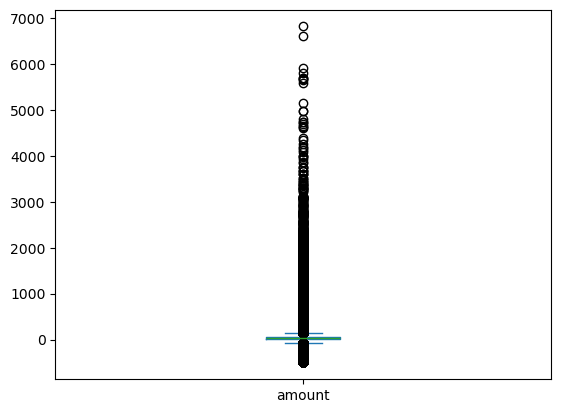

In [10]:
df_merged.amount.plot.box()

In [11]:
print(df_merged.describe())

                 id     client_id       card_id        amount  \
count  1.330592e+07  1.330592e+07  1.330592e+07  1.330592e+07   
mean   1.558402e+07  1.026812e+03  3.475268e+03  4.297604e+01   
std    4.704499e+06  5.816386e+02  1.674356e+03  8.165575e+01   
min    7.475327e+06  0.000000e+00  0.000000e+00 -5.000000e+02   
25%    1.150604e+07  5.190000e+02  2.413000e+03  8.930000e+00   
50%    1.557087e+07  1.070000e+03  3.584000e+03  2.899000e+01   
75%    1.965361e+07  1.531000e+03  4.901000e+03  6.371000e+01   
max    2.376187e+07  1.998000e+03  6.144000e+03  6.820200e+03   

       per_capita_income  yearly_income  credit_score  
count       1.330592e+07   1.330592e+07  1.330592e+07  
mean        2.397965e+04   4.668369e+04  7.139113e+02  
std         1.196712e+04   2.444509e+04  6.580271e+01  
min         0.000000e+00   1.000000e+00  4.880000e+02  
25%         1.711300e+04   3.281700e+04  6.840000e+02  
50%         2.115600e+04   4.106900e+04  7.160000e+02  
75%         2.730800e+

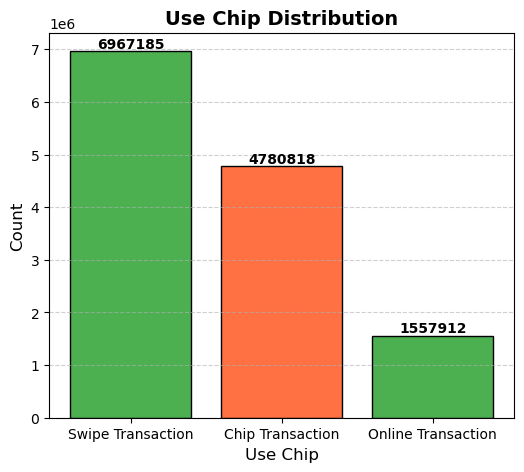

In [12]:
import matplotlib.pyplot as plt

# حساب عدد كل فئة
chip_counts = df_merged['use_chip'].value_counts()

# رسم البار
plt.figure(figsize=(6,5))
bars = plt.bar(
    chip_counts.index.astype(str),  # تحويل الفئات لنصوص (مثلاً 0,1 --> "0","1")
    chip_counts.values,
    color=['#4CAF50', '#FF7043'],   # ألوان مميزة
    edgecolor='black'
)

# إضافة القيم فوق الأعمدة
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval),
             ha='center', va='bottom', fontsize=10, weight='bold')

# تحسين الشكل
plt.title("Use Chip Distribution", fontsize=14, weight='bold')
plt.xlabel("Use Chip", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


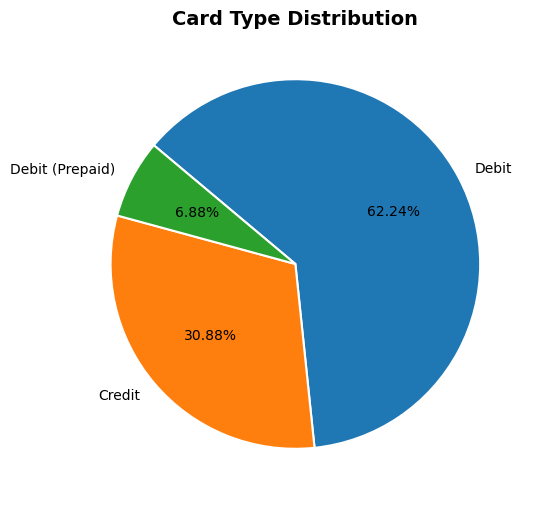

In [13]:
import matplotlib.pyplot as plt

# احسب التوزيع
card_counts = df_merged['card_type'].value_counts()

# ارسم الباي شارت
plt.figure(figsize=(8, 6))
plt.pie(
    card_counts,
    labels=card_counts.index,     # أسماء الفئات
    autopct='%.2f%%',             # النسبة المئوية بدقة
    startangle=140,               # بداية الدوران عشان الشكل يبقى أوضح
    counterclock=False,           # الاتجاه عكس عقارب الساعة
    wedgeprops={"edgecolor":"white", "linewidth":1.5}  # تحسين الحدود
)

plt.title("Card Type Distribution", fontsize=14, weight='bold')
plt.show()


In [15]:
df_merged['date'] = pd.to_datetime(df_merged['date'], errors='coerce')
df_merged['transaction_year'] = df_merged['date'].dt.year
df_merged['transaction_month'] = df_merged['date'].dt.month

In [16]:
df_merged.groupby("credit_score")["yearly_income"].mean()


credit_score
488    33686.000000
489    67170.000000
491    39521.000000
498    24173.660617
500    41843.000000
           ...     
842    44699.000000
846    34262.000000
847    46408.000000
849    41999.285714
850    43330.070484
Name: yearly_income, Length: 281, dtype: float64

In [17]:
crosstab_amount = pd.crosstab(
    df_merged["merchant_zip"],
    df_merged["card_brand"],
    values=df_merged["amount"],
    aggfunc="mean"
)
print(crosstab_amount.head(20))


card_brand           Amex   Discover  Mastercard       Visa
merchant_zip                                               
Aaronsburg            NaN        NaN   27.250000  15.980000
Abbeville       22.128000  45.702222   16.850122  29.981712
Abbotsford     162.700000        NaN   82.650526  55.132083
Abbott                NaN        NaN   28.450769  15.438000
Abbottstown           NaN        NaN   39.291111  71.451111
Aberdeen        33.636667  36.111818   32.602485  48.433459
Abernathy       10.171429        NaN   36.207619  43.135714
Abilene         52.647216  71.892908   64.177296  35.032444
Abingdon        29.206000        NaN   25.349833  39.233875
Abington         3.730000  63.476667   26.356250  19.908462
Abiquiu               NaN        NaN   17.020000  20.500000
Abita Springs         NaN  34.961250   35.387961  38.960000
Abrams          86.626364  51.598889   80.617308  75.428033
Absarokee             NaN        NaN         NaN  80.590000
Absecon         38.110000        NaN   4

<Axes: title={'center': 'Distribution of Credit Score'}, ylabel='Frequency'>

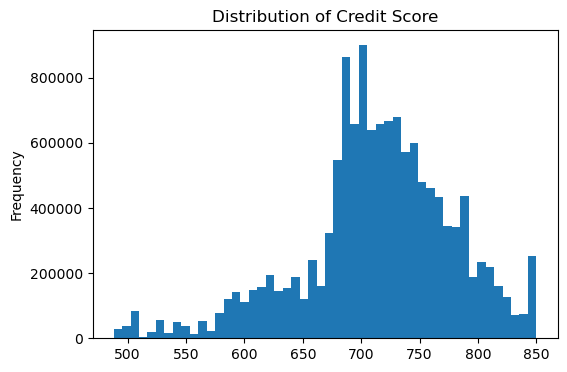

In [18]:
df_merged['credit_score'].plot.hist(bins=50, figsize=(6,4), title="Distribution of Credit Score")


In [19]:
df_merged.to_csv("new_transactions_data.csv", index=False)
